# HALO-(AC)³ BAHAMAS Quicklook

In [1]:
# import modules and set paths
import os
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import datetime

data_path = "C:/Users/Johannes/Documents/Doktor/conferences_workshops/2022_02_HALO-AC3_hackathon/data/RF09_20200205"
bahamas_path = f"{data_path}/bahamas"
bahamas_file = os.listdir(bahamas_path)[0]
bahamas_filepath = os.path.join(bahamas_path, bahamas_file)
seaice_path = f"{data_path}/sea_ice"
seaice_file = os.listdir(seaice_path)[0]
seaice_filepath = os.path.join(seaice_path, seaice_file)

On nice way of using the BAHAMAS data is to simply plot a map of the flight track with an underlying map.
As each flight can have different extents location wise, let's make a dictionary with some plot properties we want to set before we define a plotting function.
We can also define some coordinates of common locations we want to have on our map in this way.

In [2]:
# here we define the figure size, the location of the colorbar which shows the flight altitude, if we want to shrink the colorbar and the position of the legend for each flight
# we can add this for each new flight according to our needs
# fig size in centimeter 10x10 = 4*4 inch
plot_props = dict(Flight_20220205a=dict(figsize=(4, 4), cb_loc="bottom", shrink=1, l_loc=1))

coordinates = dict(EDMO=(11.28, 48.08), Keflavik=(-22.6307, 63.976), Kiruna=(20.336, 67.821), Bergen=(5.218, 60.293),
                   Torshavn=(-6.76, 62.01), Muenchen_Oberschleissheim=(11.55, 48.25), Longyearbyen=(15.46, 78.25),
                   Meiningen=(10.38, 50.56), Lerwick=(-1.18, 60.13), Ittoqqortoormiit=(-21.95, 70.48),
                   Tasiilaq=(-37.63, 65.60))

Let's define functions to read and plot the bahamas data.
Add some helper function as well.

In [3]:
def read_bahamas(bahamas_path: str) -> xr.Dataset:
    """
    Reader function for netcdf BAHAMAS data as provided by DLR.

    Args:
        bahamas_path: full path of netcdf file

    Returns: xr.DataSet with BAHAMAS data and time as dimension

    """
    ds = xr.open_dataset(bahamas_path)
    ds = ds.swap_dims({"tid": "TIME"})
    ds = ds.rename({"TIME": "time"})

    return ds


def set_xticks_and_xlabels(ax: plt.axis, time_extend: datetime.timedelta) -> plt.axis:
    """This function sets the ticks and labels of the x-axis (only when the x-axis is time in UTC).

    Options:
        -   time_extend > 7 days:               major ticks every 2 day,  minor ticks every 12 hours
        -   7 days > time_extend > 2 days:      major ticks every day, minor ticks every  6 hours
        -   2 days > time_extend > 1 days:      major ticks every 12 hours, minor ticks every  3 hours
        -   1 days > time_extend > 6 hours:     major ticks every 3 hours, minor ticks every  30 minutes
        -   6 hours > time_extend > 2 hour:     major ticks every hour, minor ticks every  15 minutes
        -   2 hours > time_extend > 15 min:     major ticks every 15 minutes, minor ticks every 5 minutes
        -   15 min > time_extend > 5 min:       major ticks every 15 minutes, minor ticks every 5 minutes
        -   else:                               major ticks every minute, minor ticks every 10 seconds

    Args:
        ax: axis in which the x-ticks and labels have to be set
        time_extend: time difference of t_end - t_start (format datetime.timedelta)

    Returns:
        ax - axis with new ticks and labels
    """

    if time_extend > datetime.timedelta(days=30):
        pass
    elif datetime.timedelta(days=30) > time_extend >= datetime.timedelta(days=7):
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))
        ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(bymonthday=range(1, 32, 2)))
        ax.xaxis.set_minor_locator(matplotlib.dates.HourLocator(byhour=range(0, 24, 12)))
    elif datetime.timedelta(days=7) > time_extend >= datetime.timedelta(days=2):
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))
        ax.xaxis.set_major_locator(matplotlib.dates.HourLocator(byhour=[0]))
        ax.xaxis.set_minor_locator(matplotlib.dates.HourLocator(byhour=range(0, 24, 6)))
    elif datetime.timedelta(days=2) > time_extend >= datetime.timedelta(hours=25):
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d\n%H:%M'))
        ax.xaxis.set_major_locator(matplotlib.dates.HourLocator(byhour=range(0, 24, 12)))
        ax.xaxis.set_minor_locator(matplotlib.dates.HourLocator(byhour=range(0, 24, 3)))
    elif datetime.timedelta(hours=25) > time_extend >= datetime.timedelta(hours=6):
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(matplotlib.dates.HourLocator(byhour=range(0, 24, 3)))
        ax.xaxis.set_minor_locator(matplotlib.dates.MinuteLocator(byminute=range(0, 60, 30)))
    elif datetime.timedelta(hours=6) > time_extend >= datetime.timedelta(hours=2):
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(matplotlib.dates.HourLocator(interval=1))
        ax.xaxis.set_minor_locator(matplotlib.dates.MinuteLocator(byminute=range(0, 60, 15)))
    elif datetime.timedelta(hours=2) > time_extend >= datetime.timedelta(minutes=15):
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(byminute=range(0, 60, 15)))
        ax.xaxis.set_minor_locator(matplotlib.dates.MinuteLocator(byminute=range(0, 60, 5)))
    elif datetime.timedelta(minutes=15) > time_extend >= datetime.timedelta(minutes=5):
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(byminute=range(0, 60, 15)))
        ax.xaxis.set_minor_locator(matplotlib.dates.MinuteLocator(byminute=range(0, 60, 5)))
    else:
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(byminute=range(0, 60, 1)))
        ax.xaxis.set_minor_locator(matplotlib.dates.SecondLocator(interval=10))

    return ax


def make_dir(folder: str) -> None:
    """
    Creates folder if it doesn't exist already.

    Args:
        folder: folder name or full path

    Returns: nothing, but creates a new folder if possible

    """
    try:
        os.makedirs(folder)
    except FileExistsError:
        pass

In [36]:
seaice = xr.open_dataset(seaice_filepath)
seaice = seaice.seaice
seaice

<xarray.DataArray 'seaice' (x: 1792, y: 1216)>
[2179072 values with dtype=float32]
Coordinates:
    lon      (x, y) float32 ...
    lat      (x, y) float32 ...
Dimensions without coordinates: x, y
Attributes:
    description:  AMSR2 sea ice concetration

In [ ]:
s1 = seaice.where(seaice < 80, 100)
s1 = seaice.where(seaice > 15, 0)
s1

C:\Users\Johannes\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:842: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
C:\Users\Johannes\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:853: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:
C:\Users\Johannes\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\Johannes\anaconda3\lib\site-packages\cartopy\crs.py:877:

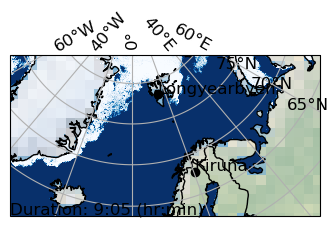

In [61]:

# def plot_bahamas_seaice_ql(flight: str, bahamas_filepath: str, seaice_filepath:str, savefig: bool = False, **kwargs):
#     """
#     Plot a map of the flight track from BAHAMAS data with the location of HALO.
#
#     Args:
#         flight: Flight name (eg. Flight_20210707a)
#         bahamas_filepath: complete path to BAHAMAS data set
#         seaice_filepath: complete path to sea ice data set from Mario's routine
#         savefig: save or show figure? (default: False)
#         **kwargs: outpath (str): where to save plot (default: bahamas_dir/plots)
#
#     Returns: Saves a png file
#
#     """
# getting the original colormap using cm.get_cmap() function
orig_map=plt.cm.get_cmap('Blues')
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()
bahamas_dir = os.path.dirname(bahamas_filepath)
# outpath = kwargs["outpath"] if "outpath" in kwargs else f"{bahamas_dir}/plots"
# make_dir(outpath)
# read in bahamas and sea ice data
bahamas = read_bahamas(bahamas_filepath)
seaice = xr.open_dataset(seaice_filepath)
# select position and time data
lon, lat, altitude, times = bahamas["IRS_LON"], bahamas["IRS_LAT"], bahamas["IRS_ALT"], bahamas["time"]
# calculate flight duration
flight_duration = pd.Timedelta((times[-1] - times[0]).values).to_pytimedelta()
# set extent of plot
pad = 2
# llcrnlat = lat.min(skipna=True) - pad
# llcrnlon = lon.min(skipna=True) - pad
# urcrnlat = lat.max(skipna=True) + pad
# urcrnlon = lon.max(skipna=True) + pad
llcrnlat = 60
llcrnlon = -30
urcrnlat = 80
urcrnlon = 50
extent = [llcrnlon, urcrnlon, llcrnlat, urcrnlat]
# set plotting options
plt.rcdefaults()
font = {'size': 12}
matplotlib.rc('font', **font)
# get plot properties
flight = "Flight_20220205a"
props = plot_props[flight]
# start plotting
fig, ax = plt.subplots(figsize=props["figsize"], subplot_kw={"projection": ccrs.NorthPolarStereo()})
ax.stock_img()
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.set_extent(extent)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.bottom_labels = False
gl.left_labels = False
# add sea ice extent
ax.pcolormesh(s1.lon, s1.lat, seaice.seaice, transform=ccrs.PlateCarree(), cmap=reversed_map)
# plot a way point every 15 minutes = 9000 seconds with a time stamp next to it
# for long, lati, time_stamp in zip(lon[9000::9000], lat[9000::9000], times[9000::9000]):
#     ax.annotate(time_stamp.dt.strftime("%H:%M").values, (long, lati), fontsize=10)
#     ax.plot(long, lati, '.r', markersize=10)

# get the coordinates for EDMO and add a label
x_edmo, y_edmo = coordinates["Kiruna"]
ax.plot(x_edmo, y_edmo, 'ok', transform=ccrs.PlateCarree())
ax.text(x_edmo + 0.1, y_edmo + 0.1, "Kiruna", fontsize=12, transform=ccrs.PlateCarree())
# plot a second airport label
x2, y2 = coordinates["Longyearbyen"]
ax.plot(x2, y2, 'ok', transform=ccrs.PlateCarree())
ax.text(x2 + 0.1, y2 + 0.1, "Longyearbyen", fontsize=12, transform=ccrs.PlateCarree())
# plot flight track and color by flight altitude
# points = ax.scatter(lon, lat, c=altitude / 1000, s=10)
# add the corresponding colorbar and decide whether to plot it horizontally or vertically
# plt.colorbar(points, ax=ax, pad=0.01, location=props["cb_loc"], label="Height (km)", shrink=props["shrink"])
# write the flight duration in the lower left corner of the map
ax.text(0, 0.01, f"Duration: {str(flight_duration)[:4]} (hr:min)", transform=ax.transAxes, fontsize=12)
# plt.tight_layout(pad=0.1)
# fig_name = f"{outpath}/{flight}_bahamas_track.png"
# if savefig:
#     plt.savefig(fig_name, dpi=100)
#     print(f"Saved {fig_name}")
# else:
plt.show()
plt.close()

<xarray.Dataset>
Dimensions:  (x: 1792, y: 1216)
Coordinates:
    lon      (x, y) float32 -80.73 -80.69 -80.65 -80.6 ... 102.4 102.4 102.3
    lat      (x, y) float32 33.96 33.98 34.01 34.04 ... 31.47 31.44 31.42 31.4
Dimensions without coordinates: x, y
Data variables:
    seaice   (x, y) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

Next let's look at some meteorological conditions during the flight

In [20]:
# read in bahamas data as dataset and resample it to 10 seconds to decrease amount of data
ds_bahamas = read_bahamas(bahamas_filepath)
ds_bahamas

<xarray.Dataset>
Dimensions:    (time: 284170)
Coordinates:
  * time       (time) datetime64[ns] 2021-06-29T07:04:42 ... 2021-06-29T14:58...
Data variables: (12/45)
    IGI_RMSX   (time) float32 ...
    IGI_RMSY   (time) float32 ...
    IGI_RMSZ   (time) float32 ...
    IRS_ALT    (time) float32 ...
    IRS_ATA    (time) float32 ...
    IRS_AXB    (time) float32 ...
    ...         ...
    TS         (time) float32 ...
    RELHUM     (time) float32 ...
    SOURCE     (time) float32 ...
    WS         (time) float32 ...
    MIXRATIOV  (time) float32 ...
    MIXRATIO   (time) float32 ...
Attributes: (12/19)
    title:                Quality controlled data of DLR measurment flight ad...
    aircraft:             D-ADLR
    project:              CIRRUS--HL
    mission:              CIRRUS--HL
    ProjectInvestigator:  Voigt
    flightname:           adlr_20210629a
    ...                   ...
    date_last_revised:    2021-6-30
    TimeInterval:         07:04:42 - 14:58:19
    comment:               Humidity is measured with SHARC and/or HUMICAP VAI...
    platform:             HALO
    instrument:           BAHAMAS
    Variablelist:          TIME IGI_RMSX IGI_RMSY IGI_RMSZ IRS_ALT IRS_ATA IR...

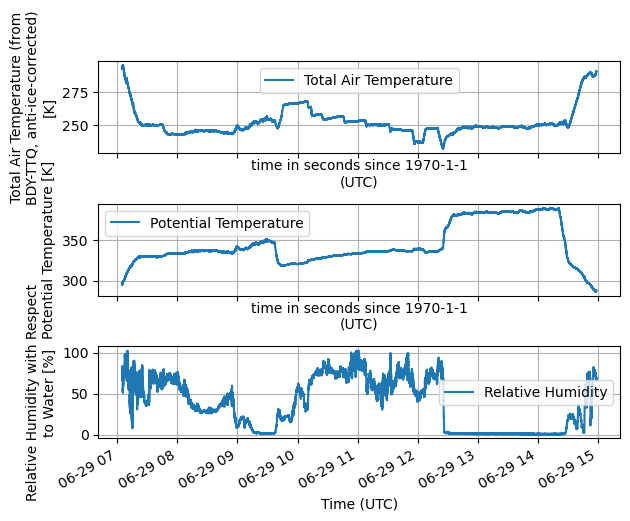

In [27]:
plt.rcdefaults()
fig, axs = plt.subplots(3, 1, sharex=True)
ds_bahamas.TAT.plot(label="Total Air Temperature", ax=axs[0], )
ds_bahamas.THETA.plot(label="Potential Temperature", ax=axs[1])
ds_bahamas.RELHUM.plot(label="Relative Humidity", ax=axs[2])
for ax in axs:
ax.grid()
ax.legend()
axs[2].set_xlabel("Time (UTC)")
plt.tight_layout()
plt.show()
plt.close()

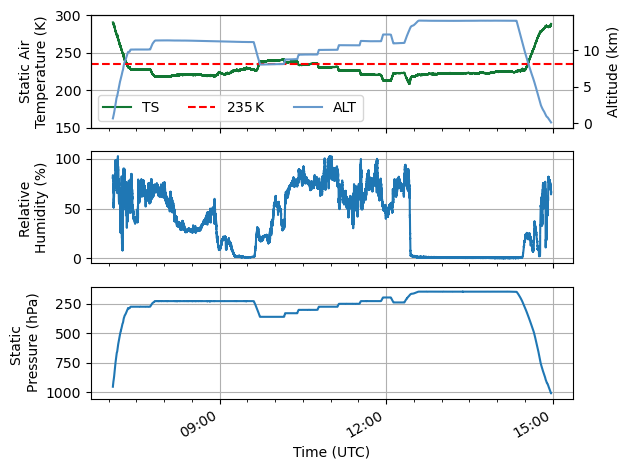

In [38]:
cb_colors = ["#6699CC", "#117733", "#CC6677", "#DDCC77", "#D55E00", "#332288"]
ylabels = ["Static Air\nTemperature (K)", "Relative \nHumidity (%)", "Static \nPressure (hPa)"]
fig, axs = plt.subplots(nrows=3)
ds_bahamas.TS.plot(color=cb_colors[1], ax=axs[0], label="TS")
axs[0].axhline(y=235, color="r", linestyle="--", label="$235\,$K")
ax2 = axs[0].twinx()
ax2.plot(ds_bahamas.time, ds_bahamas.IRS_ALT/1000, color=cb_colors[0], label="ALT")
ax2.set_ylabel("Altitude (km)")
ds_bahamas.RELHUM.plot(ax=axs[1])
ds_bahamas.PS.plot(ax=axs[2])
axs[2].invert_yaxis()
timedelta = pd.to_datetime(ds_bahamas.time[-1].values) - pd.to_datetime(ds_bahamas.time[0].values)

for ax, ylabel in zip(axs, ylabels):
ax.set_ylabel(ylabel)
ax.grid()
set_xticks_and_xlabels(ax, timedelta)


axs[2].set_xlabel("Time (UTC)")
for ax in axs[0:2]:
ax.set_xlabel("")
ax.set_xticklabels("")

handles, labels = axs[0].get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
axs[0].legend(handles+handles2, labels+labels2, ncol=3)
axs[0].set_ylim((150, 300))
# axs[2].legend(bbox_to_anchor=(0.05, 0), loc="lower left", bbox_transform=fig.transFigure, ncol=4)
# plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()
# figname = f"{outpath}/{flight}_bahamas_overview.png"
# plt.savefig(figname, dpi=100)
plt.close()